# Advances in Machine Learning with Big Data

### Trinity 2021
### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os
from mpl_toolkits.mplot3d import axes3d
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import model_selection

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

Populating the interactive namespace from numpy and matplotlib


## 6. Classification

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. **Classification**

1. Decision trees, bagging, and random forests

1. Make a start on neural networks

Load data per previous classes ...

In [2]:
df = uci_files.standard_uci_data_access()

2021-05-17 17:20:50,656 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2021-05-17 17:20:53,322 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [3]:
invalids = stock_codes.invalid_series(df)

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

### Instead of doing *regression*, lets build data for a **classification** task:

In [5]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

# predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']   # commented-out: this was the regression setup
predictors = ['log_n_codes', 'log_item_spend', 'month', 'words_per_item']

# y = invoices.log_item_spend   # commented-out: this was the regression setup
y = invoices.hour
X = invoices[predictors] 

*Can we predict the hour of the day from characteristics of the basket?*

In [6]:
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(4, include_bias=False)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)

In [7]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

### What do we actually do when we predict from $X$?

* We form a distribution for $y$, conditional on regressors.

### How about when we *classify* $X$?

We pick one object from a set. And act accordingly.

So now we model a $y$ which falls in a finite (maybe countable) set of categories, $\mathcal C$.

* e.g.     $\ \ \ \mathcal C = $ `{'negative', 'positive', 'variant', 'unresolved'}`
* we might think of these as (linked to) actions
* no ordinal structure

In [8]:
print(f"In our example, \mathcal C is {set(y)}")

In our example, \mathcal C is {7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


**Supervised learning**: an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$. Learn the distribution of the R.V. $y_i$, conditional on the stacked regressors, namely $x$:
\begin{equation}
y_i | x \ \ \sim \ \ \mathcal f_{x_i; \theta},
\end{equation}

where the $\theta$ stands-in for our parameters.

Recall, in the **linear regression:**

$\mathcal f_{x_i; \theta} \ \sim \ \mathcal N ( x_i ' \beta, \sigma^2).$


But, today we're looking at a **categorical model**: 

$f_{x_i; \theta} \ \sim \ $ a discrete distribution on $\mathcal C$ that depends on data $x_i$ and the parameters $\theta$. 

### **categorical model**: 

* a discrete distribution $f_{x_i; \theta}$ conditional on data $x_i$ and parameters $\theta$. 

In [9]:
hist_opts = dict(bins=len(set(y)), 
                 alpha=0.2, 
                 density=True, 
                 title="Non-parametric histogram, giving the distribution of hours when $x_i$'s month is Feb 2010")

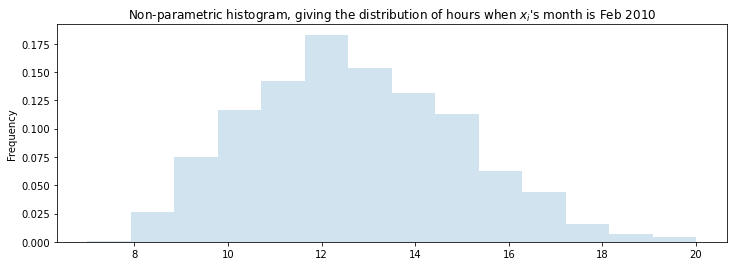

In [10]:
_ = y.loc[X.month == 201002].plot.hist(**hist_opts)

If we want to write more about $f_{x_i; \theta}$, we could use dummies, $y$ and $j$, to say:

\begin{equation}
\mathcal f_{x_i; \theta}(y) \ \ \ \ = \ \ \ \ \text{Pr}(y = j \  | \ x_i \ ; \ \theta) \ \ \ , \text{  for all } j \in \mathcal C.
\end{equation} 

In [11]:
hist_opts.update(dict(title="There's potentially a different histogram for each possible $x_i$ (here I bin by month)"))

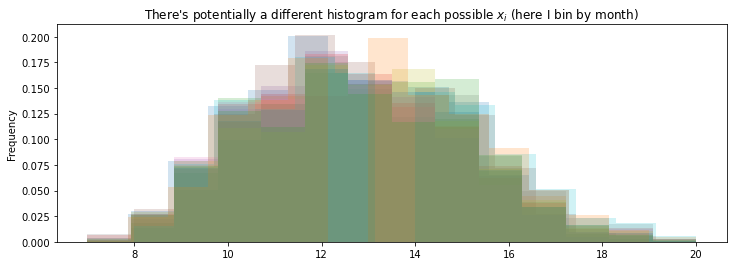

In [12]:
for month in set(X.month): y.loc[X.month == month].plot.hist(**hist_opts)

### The Bayes Classifier:

An ideal benchmark

Introduction to Statistical Learning 2.2.3:

* the *test error rate* is minimized, on average, if one *assigns each observation to the most likely class, given its predictor values*.

So, speaking 'graphically' ...

imagine the perfect situation where you know $\theta$. 

Then to classify observation $i$, select the appropriate histogram for the $x_i$, and take its highest (modal) point.

Comments on the Bayes Classifier: 

* It targets **test error rate**: so evenhanded as between type-1 or type-2 error.
   * Whenever $|\mathcal C | > 2$, there's no such thing as type-1/2 error anyway.
   

* Even though it's perfect, the Bayes Classifier still get lots wrong.
   * this is like how a regression's point-estimates are almost always wrong.

### Emulating Bayes Classification when we're fitting models

As before, we will have to postulate a model, $\hat f_{x_i; \theta}$, and then we will have to fit $\hat \theta$.

Next, we simply copy Bayes Classification, so for observation $i$, 
1. get the histogram for $x_i$ from the fitted model, 
1. and take its highest (modal) point.
1. this is the classification, $\hat y$.

### [Multinomial Logit](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#Model)

Canonical classification model. We will shortly implement this in `scikit-learn`.

For each $k \in \mathcal C$, have a coefficient vector $\beta_k$.
* that can add up to a lot of coefficients ...

Given features $x_i$, form a score ('logit') for each possibility $k$:
\begin{equation}
\text{score}(x_i, k) = \beta_k ' x_i
\end{equation}

We would *love* to use this score(/logit) to model the log-probability of $k$ given $x_i$:

\begin{equation}
\text{  Pr}(y_i = k \  | \ x_i \ ; \ \beta) = e^{\text{score}(x_i, k)}
\end{equation} 

But probabilities must add to one! 

So, adjust this approach slightly:
* For each $x_i$ to be classified, use the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) on the vector of scores. 
* Worth reading-up on this - it just adds the right normalization.

### Create our learner:

In [13]:
logistic = linear_model.LogisticRegression()

Do a 50-fold split of the data:

In [14]:
N_FOLDS = 50
kfold = model_selection.KFold(n_splits=N_FOLDS, shuffle=True)
train, test = next(kfold.split(poly_std_X, y))

**Fitting the multinomial logit** means, in scikit-learn world, maximizing a regularized likelihood:

In [15]:
logistic.fit(poly_std_X.values[train], y.values[train])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

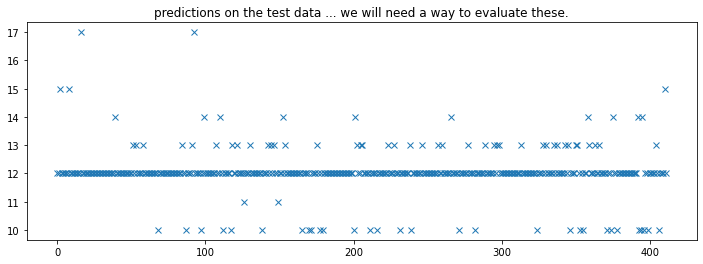

In [16]:
plt.plot(logistic.predict(poly_std_X.values[test]), ls='None', marker = 'x')
_ = plt.title('predictions on the test data ... we will need a way to evaluate these.')

In [17]:
logistic.coef_.shape

(14, 69)

Further references:
* [Scikit-learn docstring](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [Scikit-learn theory](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* [Categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood) and its relation to log-likelihood

### Confusion matrix

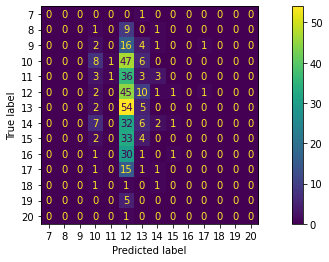

In [20]:
from sklearn import metrics
_ = metrics.plot_confusion_matrix(logistic, poly_std_X.values[test], y.values[test], display_labels=set(y.values[test]))

The proportion of observations that lie on the diagonal is the [Accuracy Score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

But this is (perhaps the leading) one of several metrics summarized in this [wikipedia entry](https://en.wikipedia.org/wiki/Confusion_matrix).

[`scikit-learn` on this](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

#### The Bayes Classifier when $|\mathcal C| = 2$

Example: COVID-19 test. $\mathcal C =$ {positive, negative}.

*Exercise*: Show that Bayes Classifier must pick 'positive' iff:
\begin{equation}
\text{Pr}(y = \text{'positive'} \  | \ x_i \ ; \ \theta) > T,
\end{equation} 
where $T= 0.5$.

As we know, this minimizes the error rate.
 * But, maybe we care more about false negatives (sensitivity, recall) than false positives (specificity).
 * -> some types of error matter more.
 
Solution?

Solution when we mind more/less about sensitivity than specificity:
* Vary $T$, sliding it up and down within the interval (0, 1). I.e. depart from Bayes.
* Pick a threshold that suits our loss function.
* Or just try each such $T$: one could track the False-Positive Rate, and the True-Positive Rate.

This gives rise to the [Receiver operating characteristic (ROC) Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:Roc-draft-xkcd-style.svg). Two settings:
1. the ideal ROC curve
2. **the ROC curve of a model in practice**

## In Conclusion

Four corners of machine learning (not exhaustive) and some examples:


| ML | Supervised | Unsupervised |  
| :--- | :---: | :---: |
| **Classification** | multinomial logit |nlp|
| **Regression** | linear regression |clustering|

All four quadrants are equally important.

Today we were 'top-left'.

We will develop many of our techniques 'bottom-left' (trees, neural nets, ...), but they can be adapted to be applied elsewhere too.

**Exercise** -  interpret this performance table on our fitted multinomial logit:

In [21]:
print(metrics.classification_report(logistic.predict(poly_std_X.values[test]), y.values[test]) )

              precision    recall  f1-score   support

           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.13      0.27      0.17        30
          11       0.02      0.50      0.04         2
          12       0.75      0.14      0.23       324
          13       0.08      0.12      0.10        41
          14       0.04      0.20      0.07        10
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0

    accuracy                           0.15       412
   macro avg       0.07      0.09      0.04       412
weighted avg       0.61      0.15      0.21       412

